# importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns

# data preprocessing

In [3]:
#loading data
file_1="/workspaces/State-of-Health-Estimation-Battery/Dataset/B0005_dis_dataset.csv"
file_2="/workspaces/State-of-Health-Estimation-Battery/Dataset/B0006_dis_dataset.csv"
dataset_1=pd.read_csv(file_1)
dataset_2=pd.read_csv(file_2)

C_max=2

#renaming columns for simplicity
dataset_1.columns=['cycle',"capacity",'voltage', 'current','temperature', 'current_load', 'voltage_load',"time"]
dataset_1["current_load"]= abs(dataset_1["current_load"])

#removing ideling / starting and ending current level data  
df_1=dataset_1[(dataset_1.current_load>=0.006)].reset_index(drop=True)

# converting time seconds->hour
df_1["time"]=df_1["time"]/3600

#calculate Soc for each cycle
cycle_count=df_1["cycle"].unique()
Soc_list=[]

# Update Soc for each reading within each cycle using Coulomb counting
for cycle in cycle_count:
    cycle_data = df_1[df_1['cycle'] == cycle]
    
    cumulative_Soc = [sum(cycle_data["capacity"])/len(cycle_data["capacity"])]
    
    for i in range(1, len(cycle_data)):
        
        delta_time = cycle_data['time'].iloc[i-1] - cycle_data['time'].iloc[i]
        
        delta_charge = cycle_data['current'].iloc[i] * delta_time
        
        cumulative_Soc.append(cumulative_Soc[-1] -delta_charge)
        
    Soc_list.extend(cumulative_Soc)

#DOD is the opposite of the soc 
df_1["Soc"] = [(q / C_max) for q in Soc_list]
df_1["Soh"]=df_1["capacity"]/C_max

# selecting parameters 
att_=["cycle","capacity","voltage","current","temperature","current_load","voltage_load","time","Soc"]
att=["cycle","current_load","voltage_load","Soc","time"]
X_axis="cycle"

#seperating dataset
X_train = df_1[att]
y_train = df_1[["Soh"]]



#renaming columns for simplicity
dataset_2.columns=['cycle',"capacity",'voltage', 'current','temperature', 'current_load', 'voltage_load',"time"]
dataset_2["current_load"]= abs(dataset_2["current_load"])

#removing ideling / starting and ending current level data  
df_2=dataset_2[(dataset_2.current_load>=0.006)].reset_index(drop=True)

# converting time seconds->hour
df_2["time"]=df_2["time"]/3600

#calculate Soc for each cycle
cycle_count=df_2["cycle"].unique()
Soc_list=[]

# Update Soc for each reading within each cycle using Coulomb counting
for cycle in cycle_count:
    cycle_data = df_2[df_2['cycle'] == cycle]
    
    cumulative_Soc = [sum(cycle_data["capacity"])/len(cycle_data["capacity"])]
    
    for i in range(1, len(cycle_data)):
        
        delta_time = cycle_data['time'].iloc[i-1] - cycle_data['time'].iloc[i]
        
        delta_charge = cycle_data['current'].iloc[i] * delta_time
        
        cumulative_Soc.append(cumulative_Soc[-1] -delta_charge)
        
    Soc_list.extend(cumulative_Soc)

#DOD is the opposite of the soc 
df_2["Soc"] = [(q / C_max) for q in Soc_list]
df_2["Soh"]=df_2["capacity"]/C_max

X_test = df_2[att]
y_test = df_2[["Soh"]]

In [4]:
#making models
regressor1 = RandomForestRegressor(n_estimators=100,random_state=0)
regressor1.fit(X_train,y_train.values.ravel())
y_pred_1= regressor1.predict(X_test)

In [5]:
regressor2 = RandomForestRegressor(n_estimators=50,random_state=0)
regressor2.fit(X_train,y_train.values.ravel())            
y_pred_2= regressor2.predict(X_test)

In [6]:
regressor3 = RandomForestRegressor(n_estimators=30,random_state=0)
regressor3.fit(X_train,y_train.values.ravel())
y_pred_3= regressor3.predict(X_test)

In [7]:
def graph_plot(b,a,model):
    plt.plot(X_test[b],y_test,color='red',label='actual',linewidth=4)
    plt.plot(X_test[b],a,color='cyan',label='Node_'+model,linewidth=1)
    plt.xlabel("cycle")
    plt.ylabel("SOH")
    rmse="Rmse = "+str(np.sqrt(metrics.mean_squared_error(y_test, a)))
    plt.figtext(0.33, -0.03, rmse, fontsize=10)
    plt.legend(loc="upper right")
    plt.suptitle("random forest regressor node:"+model)
    plt.show()
    print(np.sqrt(metrics.mean_squared_error(y_test, a)))

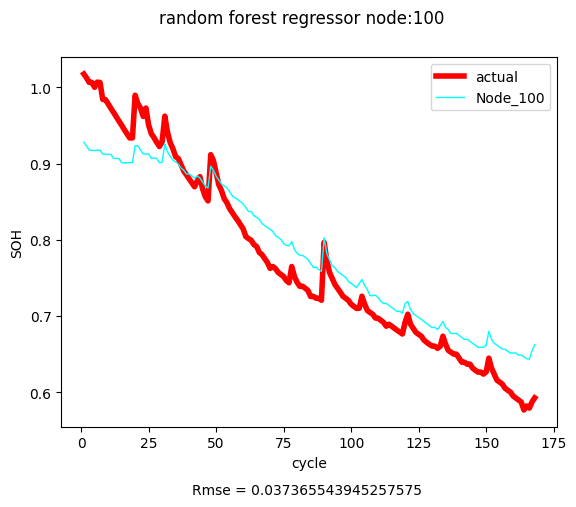

0.037365543945257575


In [8]:
graph_plot(X_axis,y_pred_1,"100")#3.05250135069885e-07

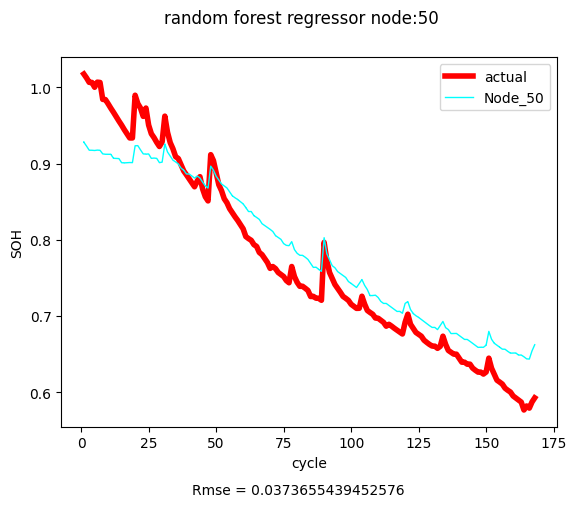

0.0373655439452576


In [9]:
graph_plot(X_axis,y_pred_2,"50")#9.70500226793594e-16

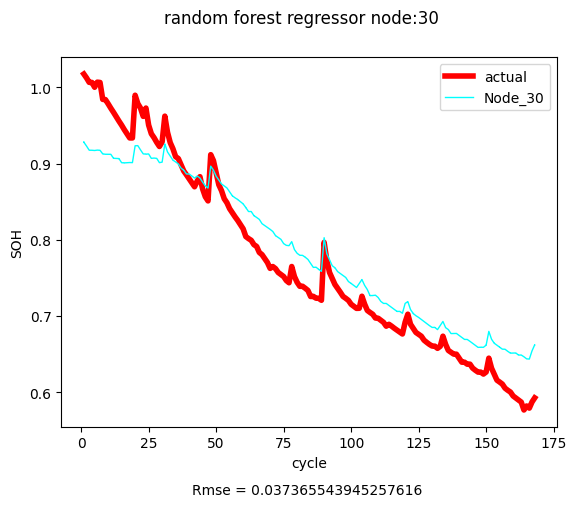

0.037365543945257616


In [10]:
graph_plot(X_axis,y_pred_3,"30")#8.933219312798214e-16